In [1]:
import re
import os
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from netCDF4 import Dataset
import geopandas as gpd
from shapely.geometry import Point
import pandas as pd
import calendar
from datetime import datetime, timedelta

### Precipitation Geo-Map, China


In [2]:
!ls /global/scratch/users/liuwenjin021011/data/CHIRPS

China_Filtered_2017.csv			chirps-v2.0.2017.days_p05.nc
FactorA_Processed_Precip_Year_2017.csv	chirps-v2.0.2018.days_p05.nc
FactorA_Processed_Precip_Year_2018.csv	chirps-v2.0.2019.days_p05.nc
FactorA_Processed_Precip_Year_2019.csv


In [7]:
# df_2017 = pd.read_csv('/global/scratch/users/liuwenjin021011/data/CHIRPS/China_Filtered_2017_first_238.csv')
# df_2017 = df_2017[df_2017['Precip'] != 0]
# df_2017 = df_2017.reset_index()[['Latitude', 'Longitude', 'Precip', 'Day']]
# df_2017.to_csv('/global/scratch/users/liuwenjin021011/data/CHIRPS/China_Filtered_Non_Zero_2017_first_238.csv')
df_2017 = pd.read_csv('/global/scratch/users/liuwenjin021011/data/CHIRPS/FactorA_Processed_Precip_Year_2017.csv')

In [8]:
# df_2018 = pd.read_csv('/global/scratch/users/liuwenjin021011/data/CHIRPS/China_Filtered_2018_first_244.csv')
# df_2018 = df_2018[df_2018['Precip'] != 0]
# df_2018 = df_2018.reset_index()[['Latitude', 'Longitude', 'Precip', 'Day']]
# df_2018.to_csv('/global/scratch/users/liuwenjin021011/data/CHIRPS/China_Filtered_Non_Zero_2018_first_244.csv')
df_2018 = pd.read_csv('/global/scratch/users/liuwenjin021011/data/CHIRPS/FactorA_Processed_Precip_Year_2018.csv')

In [9]:
# df_2019 = pd.read_csv('/global/scratch/users/liuwenjin021011/data/CHIRPS/China_Filtered_2019_first_244.csv')
# df_2019 = df_2019[df_2019['Precip'] != 0]
# df_2019 = df_2019.reset_index()[['Latitude', 'Longitude', 'Precip', 'Day']]
# df_2019.to_csv('/global/scratch/users/liuwenjin021011/data/CHIRPS/China_Filtered_Non_Zero_2019_first_244.csv')
df_2019 = pd.read_csv('/global/scratch/users/liuwenjin021011/data/CHIRPS/FactorA_Processed_Precip_Year_2019.csv')

In [10]:
df_2019.columns

Index(['time', 'latitude', 'longitude', 'precipitation', 'sum_precip_14_days'], dtype='object')

In [12]:
df_2019

,time,latitude,longitude,precipitation,sum_precip_14_days
0,2019-01-01,18.024994,73.024994,0.0,0.000000
1,2019-01-01,18.024994,73.074997,0.0,0.000000
2,2019-01-01,18.024994,73.125000,0.0,0.000000
3,2019-01-01,18.024994,73.175003,0.0,0.000000
4,2019-01-01,18.024994,73.224991,0.0,0.000000
...,...,...,...,...,...
289663995,2019-12-31,49.974998,134.774994,0.0,0.000003
289663996,2019-12-31,49.974998,134.825012,0.0,0.000008
289663997,2019-12-31,49.974998,134.875000,0.0,0.000003
289663998,2019-12-31,49.974998,134.924988,0.0,0.000002


/global/home/users/liuwenjin021011/.conda/envs/NOx_selina/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3442: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


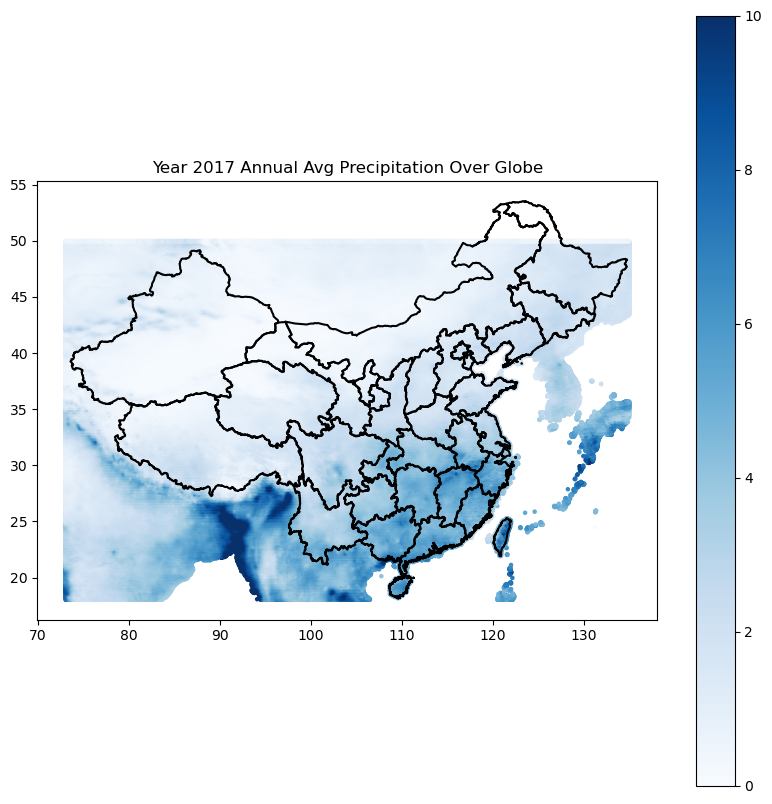

In [17]:
import geopandas as gpd
import matplotlib.pyplot as plt

def plot_precipitation_map(df, year, path_to_shp, min_day=0, max_day=365):
    # Filter the DataFrame for the specified day range
    df_filtered = df # Assuming the dataframe is pre-filtered or filtering is to be applied later

    # Calculate average precipitation for each location
    avg_precip = df_filtered.groupby(['latitude', 'longitude'])['precipitation'].mean().reset_index()

    # Convert to a GeoDataFrame and set CRS to WGS 84
    gdf = gpd.GeoDataFrame(avg_precip, geometry=gpd.points_from_xy(avg_precip['longitude'], avg_precip['latitude']))
    gdf.set_crs('EPSG:4326', inplace=True)

    # Load the shapefile and check/set its CRS
    regions = gpd.read_file(path_to_shp)
    if regions.crs is None:
        # Set to a known CRS if the shapefile lacks CRS info
        regions.set_crs('EPSG:4326', inplace=True)

    # Reproject gdf to match regions' CRS
    gdf = gdf.to_crs(regions.crs)

    # Spatial join to associate each point with a region
    gdf = gpd.sjoin(gdf, regions, how='left', op='intersects')

    # Plotting
    fig, ax = plt.subplots(figsize=(10, 10))
    regions.plot(ax=ax, color='none', edgecolor='black')  # Plotting regions
    scatter = gdf.plot(column='precipitation', ax=ax, legend=True, cmap='Blues', markersize=5, vmin=0, vmax=10)

    # Adding coastlines and province boundaries on top
    regions.boundary.plot(ax=ax, color='black')  # Enhances province boundaries

    # Optionally add China's coastlines if separate shapefile/layer available
    # coastlines.plot(ax=ax, color='black') # Uncomment and modify if coastlines data is separate

    plt.title(f'Year {year} Annual Avg Precipitation Over Globe')
    plt.show()

# Usage
path_to_shp = '/global/home/users/liuwenjin021011/logs/fall_2023/China-Province-Doundary-Shape.shp'
plot_precipitation_map(df_2017, 2017, path_to_shp=path_to_shp)


/global/home/users/liuwenjin021011/.conda/envs/NOx_selina/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3442: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


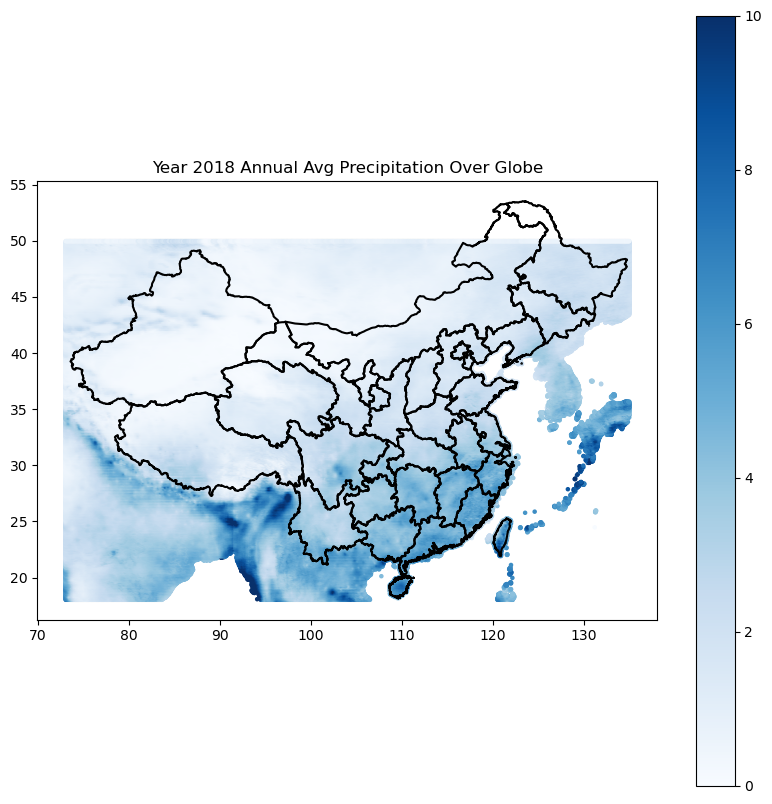

In [18]:
plot_precipitation_map(df_2018, 2018, path_to_shp=path_to_shp)

/global/home/users/liuwenjin021011/.conda/envs/NOx_selina/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3442: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


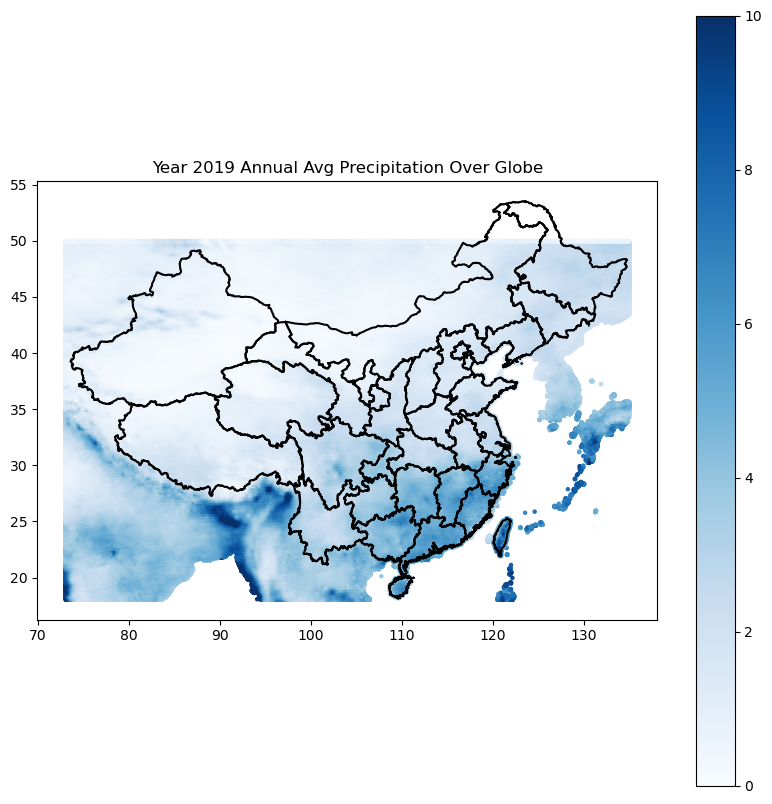

In [19]:
plot_precipitation_map(df_2019, 2019, path_to_shp=path_to_shp)

### Precipitation - Timely Trend

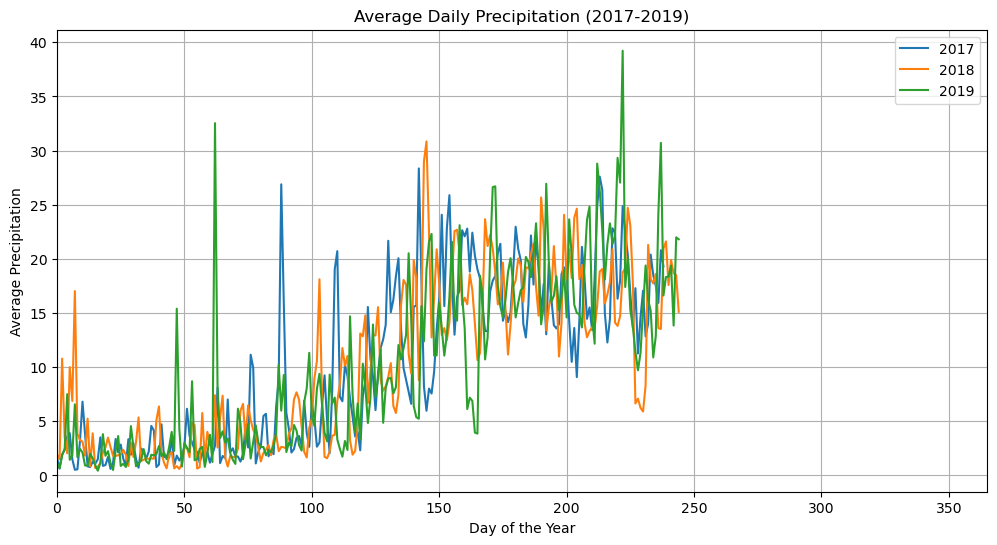

In [41]:

def plot_precipitation_time_series(df_2017, df_2018, df_2019):
    # Aggregate average precipitation per day for each year
    avg_precip_2017 = df_2017.groupby('Day')['Precip'].mean()
    avg_precip_2018 = df_2018.groupby('Day')['Precip'].mean()
    avg_precip_2019 = df_2019.groupby('Day')['Precip'].mean()

    # Create a time-series plot
    plt.figure(figsize=(12, 6))
    plt.plot(avg_precip_2017, label='2017')
    plt.plot(avg_precip_2018, label='2018')
    plt.plot(avg_precip_2019, label='2019')

    plt.title('Average Daily Precipitation (2017-2019)')
    plt.xlabel('Day of the Year')
    plt.ylabel('Average Precipitation')
    plt.legend()
    plt.grid(True)
    plt.xlim(0, 365)
    plt.show()

# Example usage
plot_precipitation_time_series(df_2017, df_2018, df_2019)


In [53]:
# Fix the Date Information

def convert_day_to_date(day, year):
    """
    Convert a day of the year and a year into the corresponding year, month, and date.

    Args:
    day (int): Day of the year (0 to 365)
    year (int): Year

    Returns:
    tuple: A tuple containing the year, month, and date
    """
    # Adjusting day to start from 1
    day += 1

    # Check if the day is valid (considering leap years)
    is_leap_year = year % 4 == 0 and (year % 100 != 0 or year % 400 == 0)
    if (is_leap_year and day > 366) or (not is_leap_year and day > 365):
        raise ValueError("Invalid day for the given year")

    date = datetime(year, 1, 1) + timedelta(days=day - 1)
    return date.year, date.month, date.day


(2020, 2, 29)


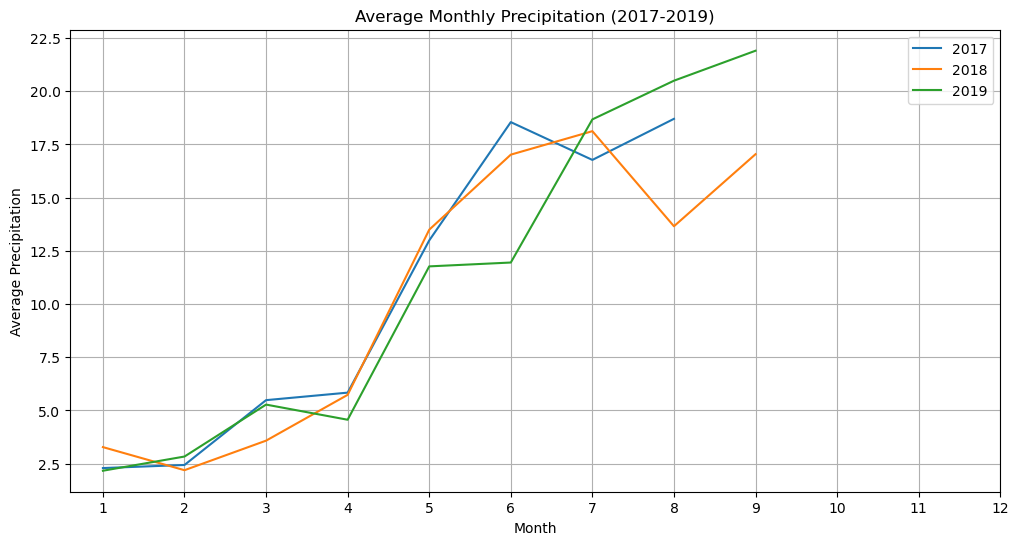

In [83]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_monthly_precipitation_time_series(df_2017, df_2018, df_2019):
    
    # Aggregate average precipitation per month for each year
    avg_precip_2017 = df_2017.groupby('Month')['Precip'].mean()
    avg_precip_2018 = df_2018.groupby('Month')['Precip'].mean()
    avg_precip_2019 = df_2019.groupby('Month')['Precip'].mean()

    # Create a time-series plot
    plt.figure(figsize=(12, 6))
    plt.plot(avg_precip_2017.index, avg_precip_2017.values, label='2017')
    plt.plot(avg_precip_2018.index, avg_precip_2018.values, label='2018')
    plt.plot(avg_precip_2019.index, avg_precip_2019.values, label='2019')

    plt.title('Average Monthly Precipitation (2017-2019)')
    plt.xlabel('Month')
    plt.ylabel('Average Precipitation')
    plt.xticks(range(1, 13))  # Set x-ticks to month numbers
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
plot_monthly_precipitation_time_series(df_2017, df_2018, df_2019)


In [6]:
df_2018

,Unnamed: 0,Latitude,Longitude,Precip,Day
0,0,22.074997,99.825010,5.477100,0
1,1,22.074997,99.875000,5.586688,0
2,2,22.125000,99.375000,4.223575,0
3,3,22.125000,99.674990,4.958535,0
4,4,22.125000,99.825010,5.874189,0
...,...,...,...,...,...
20862114,20862114,49.975000,122.375000,10.653056,244
20862115,20862115,49.975000,122.424990,9.212246,244
20862116,20862116,49.975000,122.475006,8.185660,244
20862117,20862117,49.975000,122.524994,7.953854,244
